# Tasks remaining 
1. Read survey papers and 2/3 research papers carefully to know methods and architectures that have worked for this task.

2. Implement a baseline supervised RGB to Depth regression model using a known architecture(such as an encoder-decoder architecture/U-net). Study the filters and diagnose the model.

3. Go through the codebases of proper pytorch research code, and see structure

4. Implement research papers, diagnose models, compare results, including unsupervised/semi-supervised models.

5. Report

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# In case of OSError: [Errno 107] Transport endpoint is not connected, restart Kernel

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'Depth_Estimation'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
# this changes the working directory to the folder, and allows us to perform version control operations
%cd drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/Depth_Estimation


In [3]:
%ls

 data/                     experiments/   __pycache__/   test.py
'Depth Estimation.ipynb'   model/         README.md      utils.py


In [4]:
git config --global user.email "arjun2000ashok@gmail.com"
git config --global user.name "Arjun Ashok"
!git add .
!git commit -m 'displayed image from 50k set'
!git log


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@d7caa80b44e9.(none)')
commit 3a7a339b8df5b6ade7b6a3d29fe1a321be7ed9c5 (HEAD -> master)
Author: Arjun Ashok <arjun2000ashok@gmail.com>
Date:   Sun Jul 5 11:57:19 2020 +0000

    displayed image

commit 0a0cdeb0cb9ea856ac29d8deff65f9a80053ff0c
Author: Arjun Ashok <arjun2000ashok@gmail.com>
Date:   Sun Jul 5 10:54:54 2020 +0000

    dset works

commit 5567d5f0944f06f657e363d8a5c5f67ad078e35c
Author: Arjun Ashok <arjun2000ashok@gmail.com>
Date:   Sun Jul 5 10:03:47 2020 +0000

    gitignore updated with zip

commit f4b339d6f4a4ffa6b408e370b6a21239bc918e3a
Author: Arjun Ashok <arjun2000ashok@gmail.com>
Date:   Sun Jul 5 08:46:19 2020 +0000

    Created files

commit 020fce8f00c92ac77cccc91ac865743c513ba842


In [32]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from io import BytesIO
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


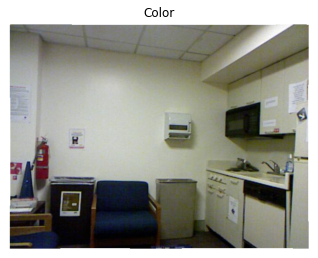

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


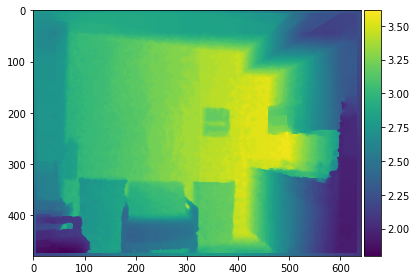

In [7]:
import test
test.main()

In [14]:
from zipfile import ZipFile

path = 'data/raw/nyu_data.zip'
input_zip = ZipFile(path)
data = {name: input_zip.read(name) for name in input_zip.namelist()}

In [67]:
nyu_train = []

for row in data['data/nyu2_train.csv'].decode('UTF-8').split('\n'):
  if len(row) > 0:
    nyu_train.append(row.split(',')) #stores the image and its depth

nyu_test = []

for row in data['data/nyu2_test.csv'].decode('UTF-8').split('\n'):
  if len(row) > 0:
    nyu_test.append(row.split(',')) #stores the image and its depth    

In [68]:
len(nyu_test)

654

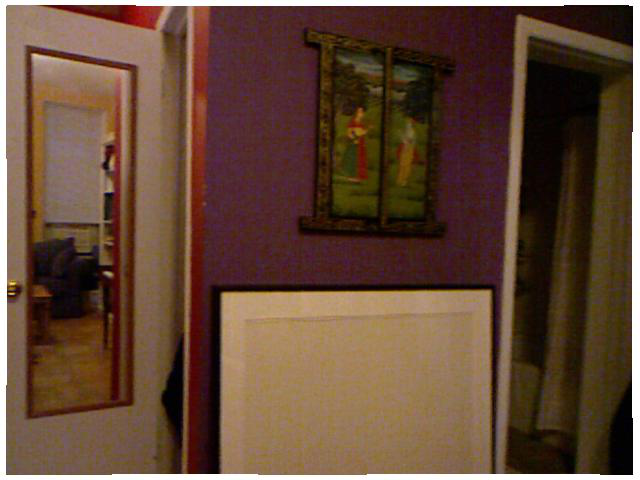

In [105]:
sample = nyu_train[0]
maxDepth = 1000.0
x = np.clip(np.asarray(Image.open( BytesIO(data[sample[0]]) )).reshape(480,640,3)/255,0,1)
# y = np.clip(np.asarray(Image.open( BytesIO(data[sample[1]]) )).reshape(480,640)/255*maxDepth,0,maxDepth)

y = np.asarray(Image.open( BytesIO(data[sample[1]]) )).reshape(480,640)
# y_unclipped_unnormalised = np.asarray(Image.open( BytesIO(data[sample[1]]) )).reshape(480,640)
# y = 255/y

Image.fromarray((x * 255).astype(np.uint8), mode = 'RGB')
# Image.fromarray((y * 255).astype(np.uint8), mode = 'L')

In [102]:
import random
random.shuffle(nyu_train)